# Inference EfficientDet

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernel for this competition about Weighted Boxes Fusion:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)


I hope it is useful for you, my friends! If you didn't read this kernel, don't forget to do it! :)


Here I would like to share with you inference part for my training kernel:

- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)

In [1]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
#!mkdir ../weightedboxesfusion
#!unzip ../weightedboxesfusion.zip -d ../weightedboxesfusion

In [2]:
import sys
sys.path.insert(0, "../../efficientdet-pytorch")
sys.path.insert(0, "../../omegaconf")
sys.path.insert(0, "../weightedboxesfusion")

import cv2
import gc
import time
from glob import glob
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval, DetBenchTrain
from effdet.efficientdet import HeadNet

from ensemble_boxes import *


In [3]:
DATA_DIR = '../../data/wheat/'
!ls $DATA_DIR

global-wheat-detection.zip  sample_submission.csv  test  train	train.csv


In [46]:
df_train = pd.read_csv(f'{DATA_DIR}/train.csv')
df_train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [47]:
bboxs = np.stack(df_train['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df_train[column] = bboxs[:,i]
df_train.drop(columns=['bbox'], inplace=True)

In [48]:
df_train.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [49]:
df_train.dtypes

image_id     object
width         int64
height        int64
source       object
x           float64
y           float64
w           float64
h           float64
dtype: object

In [7]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [8]:
#DATA_ROOT_PATH = '../input/global-wheat-detection/test'

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_DIR}/test/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [12]:
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_DIR}/test/*.jpg')]),
    transforms=get_valid_transforms()
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

#net = load_net('../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin')
net = load_net('./effdet5-cutmix-augmix/best-fold-0.pth')


In [12]:
type(net.model)

effdet.efficientdet.EfficientDet

In [14]:
def make_predictions(net, images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.45, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

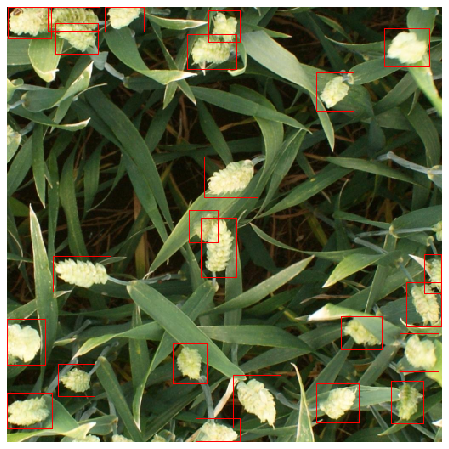

In [15]:
import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_predictions(net, images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample);

In [16]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [50]:
def predict_test_set_for_pseudo(net):
    results = []

    for images, image_ids in data_loader:
        predictions = make_predictions(net, images)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            #result = {
            #    'image_id': image_id,
            #    'PredictionString': format_prediction_string(boxes, scores),
            #    'boxes': boxes
            #}
            for b in boxes.astype(np.float32):
                results.append({
                    'image_id': 'chicm'+image_id,
                    'height': 1024,
                    'width': 1024,
                    'source': 'pseudo',
                    'x': b[0],
                    'y': b[1],
                    'w': b[2],
                    'h': b[3]
                })
    return results

In [51]:
results = predict_test_set_for_pseudo(net)

In [52]:
df_pred = pd.DataFrame(results)
df_pred.head()

,image_id,height,width,source,x,y,w,h
0,chicm2fd875eaa,1024,1024,pseudo,108.0,586.0,137.0,84.0
1,chicm2fd875eaa,1024,1024,pseudo,532.0,866.0,112.0,124.0
2,chicm2fd875eaa,1024,1024,pseudo,0.0,735.0,90.0,108.0
3,chicm2fd875eaa,1024,1024,pseudo,390.0,793.0,80.0,93.0
4,chicm2fd875eaa,1024,1024,pseudo,457.0,497.0,84.0,139.0


In [53]:
df_train.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [54]:
df_pseudo = pd.concat([df_train, df_pred])
df_pseudo.shape

(148051, 8)

In [56]:
df_pseudo.tail()

,image_id,width,height,source,x,y,w,h
253,chicmcc3532ff6,1024,1024,pseudo,260.0,839.0,126.0,84.0
254,chicmcc3532ff6,1024,1024,pseudo,411.0,220.0,88.0,85.0
255,chicmcc3532ff6,1024,1024,pseudo,0.0,768.0,47.0,81.0
256,chicmcc3532ff6,1024,1024,pseudo,727.0,737.0,88.0,83.0
257,chicmcc3532ff6,1024,1024,pseudo,5.0,479.0,67.0,77.0


In [58]:
df_pseudo.shape

(148051, 8)

In [71]:
#TRAIN_ROOT_PATH = f'{DATA_DIR}/test'

class PseudoDataset(Dataset):
    def __init__(self, meta, transforms=None, test=False):
        super().__init__()
        self.image_ids = meta['image_id'].unique()
        self.meta = meta
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]       
        image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return len(self.image_ids)
    
    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        #image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        
        records = self.meta[self.meta['image_id'] == image_id]
        if 'chicm' in image_id:
            image_id = image_id[5:]
            image = cv2.imread(f'{DATA_DIR}/test/{image_id}.jpg', cv2.IMREAD_COLOR)
        else:
            image = cv2.imread(f'{DATA_DIR}/train/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        
        #print(records)
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #print('>>>boxes:', boxes)
        return image, boxes


    def load_data_from_predictions(self, index):
        image_id = self.preds[index]['image_id']
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = self.preds[index]['boxes'].copy()
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        return image, boxes

In [72]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.Resize(height=512, width=512, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [73]:
train_dataset = PseudoDataset(
    meta=df_pseudo,
    transforms=get_train_transform(),
    test=False,
)

In [74]:
len(train_dataset)

3383

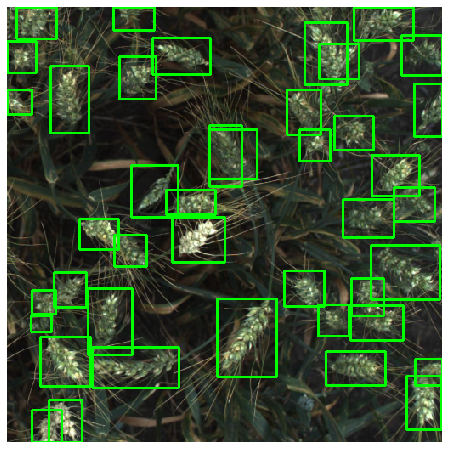

In [75]:
image, target, image_id = train_dataset[9]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

# Fitter

In [76]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

import warnings

warnings.filterwarnings("ignore")

class Fitter:
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=0.9, weight_decay=0.0001)
        #self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        #self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.5)

    def fit(self, train_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                print(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            print(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.scheduler.step()
            self.epoch += 1

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

        return summary_loss


In [77]:
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 3
    lr = 0.005

    # -------------------
    verbose = True
    verbose_step = 1


def collate_fn(batch):
    return tuple(zip(*batch))

def run_training(train_det_model):
    device = torch.device('cuda')
    train_det_model.to(device)
    #net.cuda()
    #net.model = nn.DataParallel(net.model)
    #train_dataset = get_train_val_datasets(TrainGlobalConfig.ifold)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )

    #net.train()
    fitter = Fitter(model=train_det_model, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader)

In [78]:
config = get_efficientdet_config('tf_efficientdet_d5')
config.num_classes = 1
config.image_size = 512
train_det_model = DetBenchTrain(net.model, config)


In [80]:
run_training(train_det_model)


2020-05-24T06:40:17.426701
LR: 0.01
[RESULT]: Train. Epoch: 0, summary_loss: 0.82783, time: 673.00356

2020-05-24T06:51:30.430750
LR: 0.005
[RESULT]: Train. Epoch: 1, summary_loss: 0.59720, time: 672.69776

2020-05-24T07:02:43.128929
LR: 0.0025
[RESULT]: Train. Epoch: 2, summary_loss: 0.53108, time: 673.36226

2020-05-24T07:13:56.491647
LR: 0.00125
[RESULT]: Train. Epoch: 3, summary_loss: 0.49439, time: 673.98400


In [33]:
def create_eval_model(train_det_model):
    config = get_efficientdet_config('tf_efficientdet_d5')
    config.num_classes = 1
    config.image_size=512

    eval_det_model = DetBenchEval(train_det_model.model, config)
    eval_det_model.eval();
    return eval_det_model.cuda()

#net = load_net('../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin')
eval_det_model = create_eval_model(train_det_model)

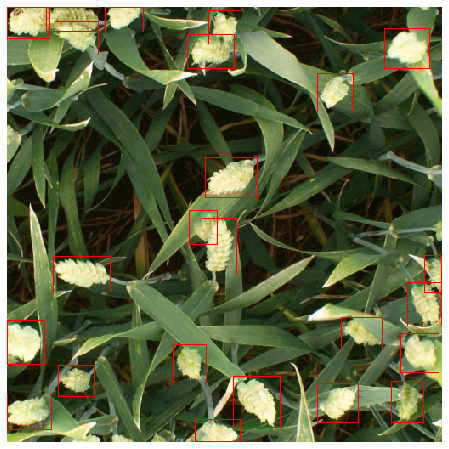

In [34]:
for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_predictions(eval_det_model, images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample);

In [ ]:
def predict_test_set(net):
    results = []

    for images, image_ids in data_loader:
        predictions = make_predictions(net, images)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }
            results.append(result)
    
    return results

In [35]:
results = predict_test_set(eval_det_model)

In [36]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.9992 390 794 79 91 0.9986 121 842 84 74 0.99...
1,f5a1f0358,0.9959 666 107 84 95 0.9959 542 268 114 117 0....
2,51f1be19e,0.9945 609 81 159 177 0.9929 805 761 111 95 0....
3,51b3e36ab,0.9993 5 819 101 103 0.9983 362 156 101 95 0.9...
4,cb8d261a3,0.9988 752 711 85 86 0.9983 167 904 89 87 0.99...


### Thank you for reading my kernel!

If you didn't read training and WBF kernels:

- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)


Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.